In [260]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import imutils
import math
from collections import defaultdict

(Text(0.5, 1.0, 'Original Image'), ([], []), ([], []))

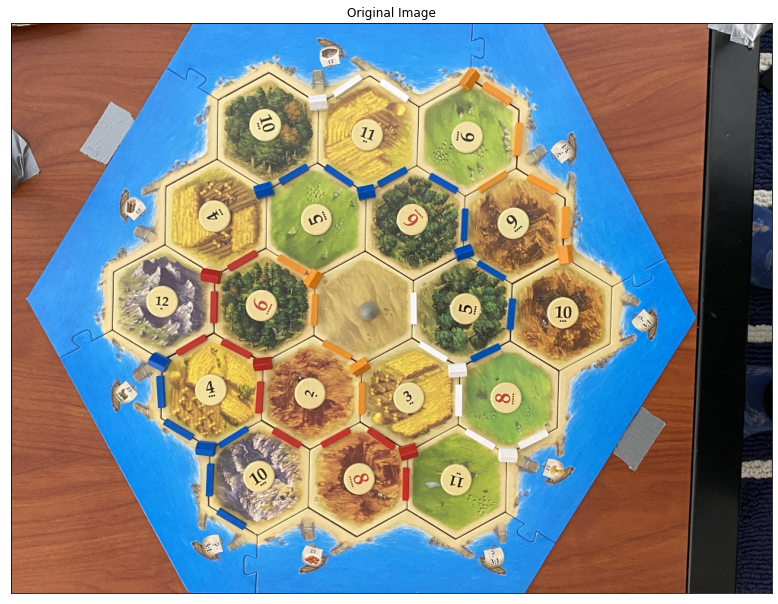

In [261]:
############################################
# Read image and get canny edge detection
############################################

# read img
img = cv.imread('photos/testimg3.jpg')[:,:,::-1]
# pad_size = 100
# img = cv.copyMakeBorder(img,pad_size, pad_size, pad_size, pad_size,cv.BORDER_CONSTANT,value=(0, 0, 0))
img = imutils.resize(img, width=1000)
img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)

# get canny
edges = cv.Canny(img,100,300)

# see img
plt.figure(figsize=(30, 30))
plt.subplot(121),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

20


([], [])

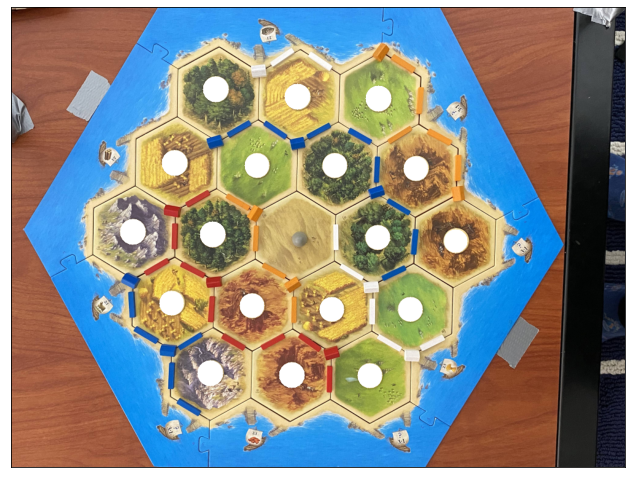

In [262]:
############################################
# get each number circle
############################################

circles = cv.HoughCircles(img_gray,cv.HOUGH_GRADIENT_ALT,1,20,
                            param1=50,param2=.92,minRadius=10,maxRadius=50)
circles = np.uint16(np.around(circles))[0,:,0:3]
circles_img = img.copy()
average_circle_radius = 20
for circ in circles:
    cv.circle(circles_img,(circ[0],circ[1]),circ[2],(255,255,255),-1)
print(average_circle_radius)
plt.figure(figsize=(11,11))
plt.imshow(circles_img)
plt.xticks([])
plt.yticks([])

131.03591724104032


([], [])

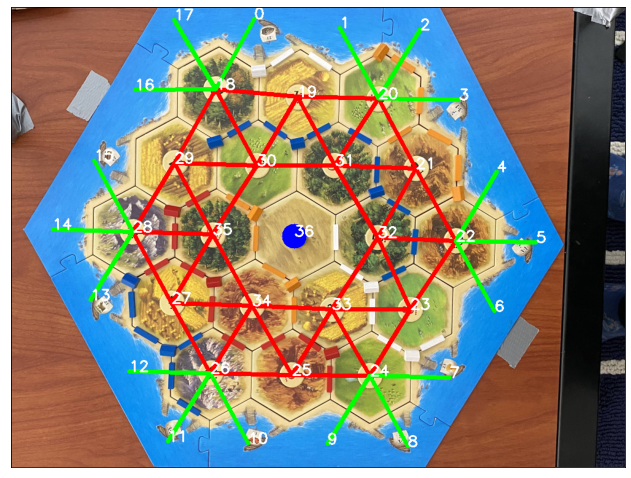

In [263]:
#########################
# get average distance
#########################

num_short_distances = 3 * 6 + 4 * 6 + 6 * 5
all_distances = []

circles = np.array(circles, dtype=np.float64)
def distanceBetweenCircles(c1, c2):
    return math.sqrt(((c1[0] - c2[0]) ** 2) + ((c1[1] - c2[1]) ** 2))

for i in range(len(circles)):
    for j in range(len(circles)):
        if (i != j):
            all_distances.append(distanceBetweenCircles(circles[i], circles[j]))

all_distances.sort()


short_distances_sum = 0
for i in range(num_short_distances):
    short_distances_sum += all_distances[i]

average_distance = short_distances_sum / num_short_distances
print(average_distance)
distance_range = 55

img_copy = img.copy()
circles_map = defaultdict(list)
for i in range(len(circles)):
    for j in range(len(circles)):
        if (distanceBetweenCircles(circles[i], circles[j]) >= average_distance - distance_range and distanceBetweenCircles(circles[i], circles[j]) <= average_distance + distance_range):
            circles_map[i].append(j)
            cv.line(img_copy, (int(circles[i][0]), int(circles[i][1])), (int(circles[j][0]), int(circles[j][1])), (255, 0, 0), 5)

def angleBetweenCircles(c1, c2):
    delta_x = c2[0] - c1[0]
    delta_y = c2[1] - c1[1]
    return math.atan2(delta_y, delta_x)

# get outer circles
outer_circles = []
inner_circles = []
outer_real_circles = []
current_outer_circle = None
top_most_outer_y = 9999
top_most_outer_real_y = 9999
top_most_inner_y = 9999
for key in circles_map:
    val = circles_map[key]
    if (len(val) == 3):
        cur_angles = []
        for other_c in val:
            cur_angles.append((math.pi * 2) + angleBetweenCircles(circles[key], circles[other_c]))
        cur_angles.sort()
        if (cur_angles[1] - cur_angles[0] - (math.pi / 6) > 1):
            cur_angles[0] += (math.pi * 2)
        if (cur_angles[2] - cur_angles[1] - (math.pi / 6) > 1):
            cur_angles[2] -= (math.pi * 2)
        cur_angles.sort()
        
        # add other angles
        maxAngle = cur_angles[2]
        for i in range(3):
            maxAngle += math.pi / 3
            newX = circles[key][0] + (average_distance * math.cos(maxAngle))
            newY = circles[key][1] + (average_distance * math.sin(maxAngle))
            cv.line(img_copy, (int(circles[key][0]), int(circles[key][1])), (int(newX), int(newY)), (0, 255, 0), 5)
            outer_circles.append([newX, newY])
            top_most_outer_y = min(top_most_outer_y, newY)
            if (i == 1):
                current_outer_circle = [newX, newY]
            if (i == 0):
                next_outer_circle = [newX, newY]

    elif (len(val) == 5):
        inner_circles.append(circles[key])
        top_most_inner_y = min(top_most_inner_y, circles[key][1])
    
    if (len(val) != 5):
        outer_real_circles.append(circles[key])
        top_most_outer_real_y = min(top_most_outer_real_y, circles[key][1])

# get center circle
average_inner_x = 0
average_inner_y = 0
for c in inner_circles:
    average_inner_x += c[0]
    average_inner_y += c[1]
average_inner_x /= 6
average_inner_y /= 6

center_circle = [average_inner_x, average_inner_y]

cv.circle(img_copy, (int(average_inner_x), int(average_inner_y)), 20, (0, 0, 255), -1)

# number
def sort_circles(c):
  return angleBetweenCircles(c, center_circle)

cars = ['Ford', 'Mitsubishi', 'BMW', 'VW']

# find top most outer circle
outer_circles.sort(key=sort_circles)
top_most_outer_y_index = 0
num_outer_circles = len(outer_circles)
for i in range(len(outer_circles)):
    cur_c = outer_circles[i]
    if (cur_c[1] == top_most_outer_y):
        top_most_outer_y_index = i
        break
outer_circles += outer_circles

# find top most outer real circle
outer_real_circles.sort(key=sort_circles)
top_most_outer_real_y_index = 0
num_outer_real_circles = len(outer_real_circles)
for i in range(len(outer_real_circles)):
    cur_c = outer_real_circles[i]
    if (cur_c[1] == top_most_outer_real_y):
        top_most_outer_real_y_index = i
        break
outer_real_circles += outer_real_circles

# find top most inner circles
inner_circles.sort(key=sort_circles)
top_most_inner_y_index = 0
num_inner_circles = len(inner_circles)
for i in range(len(inner_circles)):
    cur_c = inner_circles[i]
    if (cur_c[1] == top_most_inner_y):
        top_most_inner_y_index = i
        break
inner_circles += inner_circles


points = []
point_num = 0
for i in range(top_most_outer_y_index, top_most_outer_y_index + num_outer_circles):
    cur_c = outer_circles[i]
    # cv.putText(img_copy, str(point_num), (int(cur_c[0]), int(cur_c[1])), cv.FONT_HERSHEY_SIMPLEX, .8, (255, 255, 255), 2)
    point_num += 1
    points.append([cur_c[0], cur_c[1]])

for i in range(top_most_outer_real_y_index, top_most_outer_real_y_index + num_outer_real_circles):
    cur_c = outer_real_circles[i]
    #cv.putText(img_copy, str(point_num), (int(cur_c[0]), int(cur_c[1])), cv.FONT_HERSHEY_SIMPLEX, .8, (255, 255, 255), 2)
    point_num += 1
    points.append([cur_c[0], cur_c[1]])
    
for i in range(top_most_inner_y_index, top_most_inner_y_index + num_inner_circles):
    cur_c = inner_circles[i]
    # cv.putText(img_copy, str(point_num), (int(cur_c[0]), int(cur_c[1])), cv.FONT_HERSHEY_SIMPLEX, .8, (255, 255, 255), 2)
    point_num += 1
    points.append([cur_c[0], cur_c[1]])


# cv.putText(img_copy, str(point_num), (int(center_circle[0]), int(center_circle[1])), cv.FONT_HERSHEY_SIMPLEX, .8, (255, 255, 255), 2)
points.append([center_circle[0], center_circle[1]])

for i in range(len(points)):
    cur_c = points[i]
    cv.putText(img_copy, str(i), (int(cur_c[0]), int(cur_c[1])), cv.FONT_HERSHEY_SIMPLEX, .8, (255, 255, 255), 2)

plt.figure(figsize=(11,11))
plt.imshow(img_copy)
plt.xticks([])
plt.yticks([])




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], [])

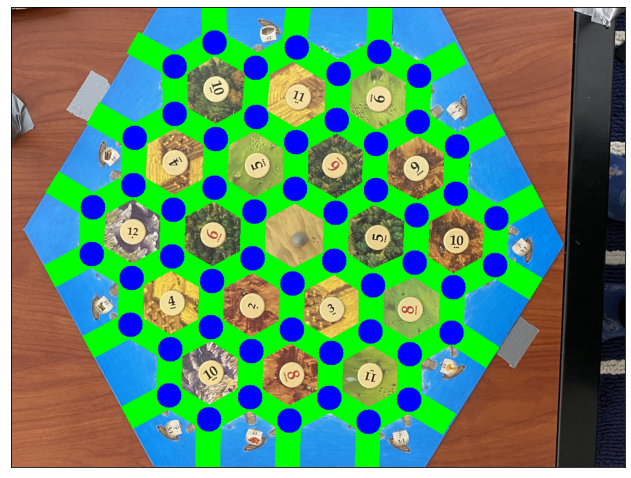

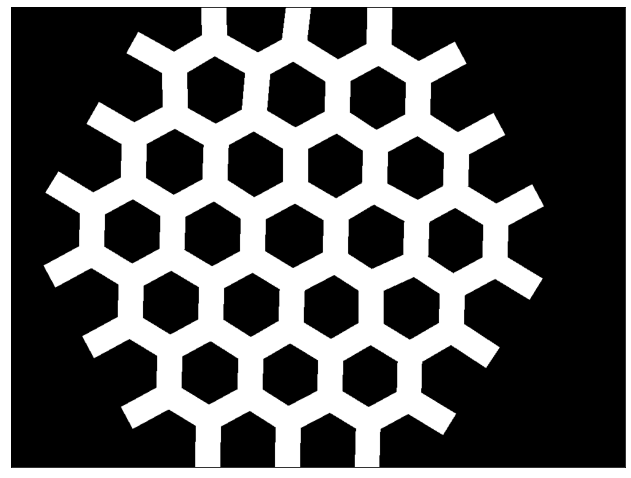

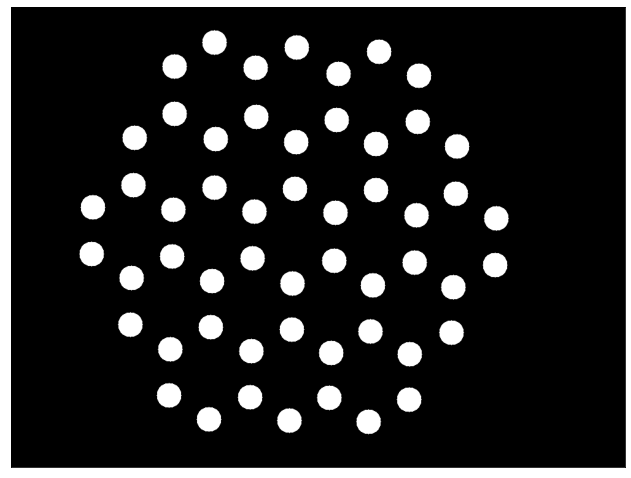

In [264]:
###########################
# Find settlement locations
###########################


test_img = img.copy()
# go around ordered circle and find all neighbors
neighbor_sets = {}
neighbors = []
for i in range(len(points)):
    neighbors = []
    color = list(np.random.random(size=3) * 256)
    for j in range(len(points)):
        if (distanceBetweenCircles(points[i], points[j]) >= average_distance - distance_range and distanceBetweenCircles(points[i], points[j]) <= average_distance + distance_range):
            neighbors.append(j)
            cv.line(test_img, (int(points[i][0]), int(points[i][1])), (int(points[j][0]), int(points[j][1])), color, 5)
    neighbor_sets[i] = neighbors

check_loc_img = img.copy()
road_mask_all = np.zeros(img.shape)
settlement_mask_all = np.zeros(img.shape)

check_road_radius = 50
check_settlement_radius = 20

def get_point_from_angle_dist(orig, ang, dist):
    return (orig[0]+dist*math.cos(ang), orig[1]+dist*math.sin(ang))

# find possible road locations
box_w = 80
box_h = 40
road_locs = []
road_masks = []
for num in neighbor_sets:
    first_pt = points[num]
    for neighbor in neighbor_sets[num]:
        road_mask = np.zeros(img.shape)
        second_pt = points[neighbor]
        road_loc = (int((first_pt[0]+second_pt[0])/2), int((first_pt[1]+second_pt[1])/2))
        road_locs.append({"pts":[first_pt, second_pt], "loc":road_loc, "mask":road_mask, "neighbors":[num, neighbor]})
        # cv.circle(check_loc_img, road_loc, 30, (0,255,0), 2)
        # compute rectangle corners
        ang = angleBetweenCircles(first_pt, second_pt)
        dist = np.sqrt((box_h/2)**2 + (box_w/2)**2)
        alpha = math.atan2((box_h/2),(box_w/2))
        beta = np.pi/2-alpha
        ang1 = ang+beta
        ang2 = ang1+2*alpha
        ang3 = ang-beta
        ang4 = ang3-2*alpha
        pt1 = get_point_from_angle_dist(road_loc, ang1, dist)
        pt2 = get_point_from_angle_dist(road_loc, ang2, dist)
        pt3 = get_point_from_angle_dist(road_loc, ang3, dist)
        pt4 = get_point_from_angle_dist(road_loc, ang4, dist)
        box_pts = np.array([[pt1],[pt2],[pt4],[pt3]],np.int32)
        box_pts = box_pts.reshape((-1, 1, 2))
        # cv.polylines(check_loc_img, [box_pts], True, (0,255,0), 2)
        cv.fillPoly(check_loc_img, [box_pts], (0,255,0))
        cv.fillPoly(road_mask, [box_pts], (255,255,255))
        cv.fillPoly(road_mask_all, [box_pts], (255,255,255))
        # cv.circle(road_mask_all, road_loc, check_road_radius, (255,255,255), -1)
        # cv.circle(road_mask, road_loc, check_road_radius, (255,255,255), -1)
        road_masks.append(road_mask)

## find possible settlement locations
# make copy of neighbors
# find dists between neighboring neighbors
# find centroid of each neighbor triplet
settlement_locs = []
settlement_masks = []
for num in neighbor_sets:
    first_pt = points[num]
    neighbors_copy = neighbor_sets[num]

    # compute dists between all neighbors
    neighbor_pts = np.array(points)[np.array(neighbors_copy)]
    n_dists = []
    for i, n_1 in enumerate(neighbors_copy):
        for j, n_2 in enumerate(neighbors_copy):
            if (i < j):
                dist = distanceBetweenCircles(neighbor_pts[i], neighbor_pts[j])
                if dist < 200:
                    n_dists.append([n_1,n_2])
    for pair in n_dists:
        settlement_mask = np.zeros(img.shape)
        second_pt = points[pair[0]]
        third_pt = points[pair[1]]
        settlement_loc = (int((first_pt[0]+second_pt[0]+third_pt[0])/3),int((first_pt[1]+second_pt[1]+third_pt[1])/3))
        settlement_locs.append({"pts":[first_pt, second_pt, third_pt], "loc":settlement_loc, "mask":settlement_mask, "neighbors":pair})
        cv.circle(check_loc_img, settlement_loc, 20, (0,0,255), -1)
        cv.circle(settlement_mask_all, settlement_loc, check_settlement_radius, (255,255,255), -1)
        settlement_masks.append(settlement_mask)

plt.figure(figsize=(11,11))
plt.imshow(check_loc_img)
plt.xticks([])
plt.yticks([])
plt.figure(figsize=(11,11))
plt.imshow(road_mask_all)
plt.xticks([])
plt.yticks([])
plt.figure(figsize=(11,11))
plt.imshow(settlement_mask_all)
plt.xticks([])
plt.yticks([])

([], [])

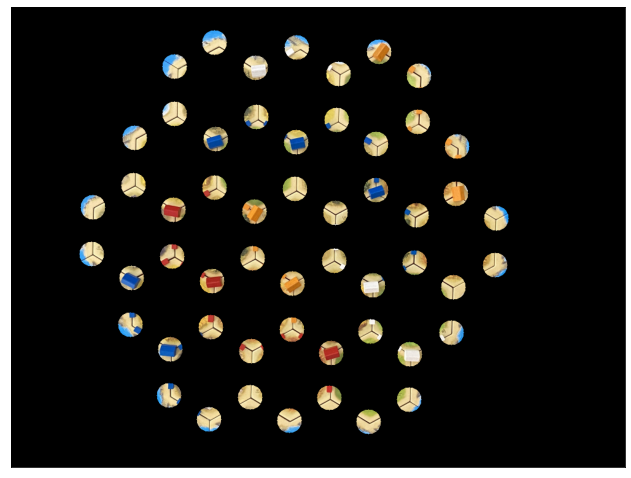

In [265]:

possible_settles_img = np.where(settlement_mask_all==0, 0, img)


plt.figure(figsize=(11,11))
plt.imshow(possible_settles_img)
plt.xticks([])
plt.yticks([])

In [266]:
##########################
# Get color for each point
##########################

def getTypeFromAvgHSV(hsv):
    type = 'none'
    if hsv[0] >= 15 and hsv[0] <= 25 and \
        hsv[1] >= 100 and hsv[1] <= 160 and \
        hsv[2] >= 160 and hsv[2] <= 225:
        type = 'wheat'
    elif hsv[0] >= 9 and hsv[0] <= 27 and \
        hsv[1] >= 80 and hsv[1] <= 145 and \
        hsv[2] >= 100 and hsv[2] <= 180:
        type = 'brick'
    elif hsv[0] >= 50 and hsv[0] <= 145 and \
        hsv[1] >= 28 and hsv[1] <= 55 and \
        hsv[2] >= 100 and hsv[2] <= 175:
        type = 'stone'
    elif hsv[0] >= 26 and hsv[0] <= 75 and \
        hsv[1] >= 25 and hsv[1] <= 110 and \
        hsv[2] >= 75 and hsv[2] <= 135:
        type = 'wood'
    elif hsv[0] >= 32 and hsv[0] <= 45 and \
        hsv[1] >= 80 and hsv[1] <= 150 and \
        hsv[2] >= 120 and hsv[2] <= 200:
        type = 'sheep'
    return type


e = 10
num_pts = 10
tiles = {}
for i in range(18, 36):
    circ = points[i]
    avg = [0, 0, 0]
    for j in range(1,num_pts+1):
        x = int(circ[0] + (e+average_circle_radius)*np.cos(j*2*np.pi/10))
        y = int(circ[1] + (e+average_circle_radius)*np.sin(j*2*np.pi/10))
        avg += img_hsv[y, x, :]
    avg = avg/num_pts
    # points[i].append(getTypeFromAvgHSV(avg))
    tiles[i] = getTypeFromAvgHSV(avg)

print(tiles)

{18: 'wood', 19: 'wheat', 20: 'sheep', 21: 'brick', 22: 'brick', 23: 'sheep', 24: 'sheep', 25: 'brick', 26: 'stone', 27: 'wheat', 28: 'stone', 29: 'wheat', 30: 'sheep', 31: 'wood', 32: 'wood', 33: 'wheat', 34: 'brick', 35: 'wood'}


([], [])

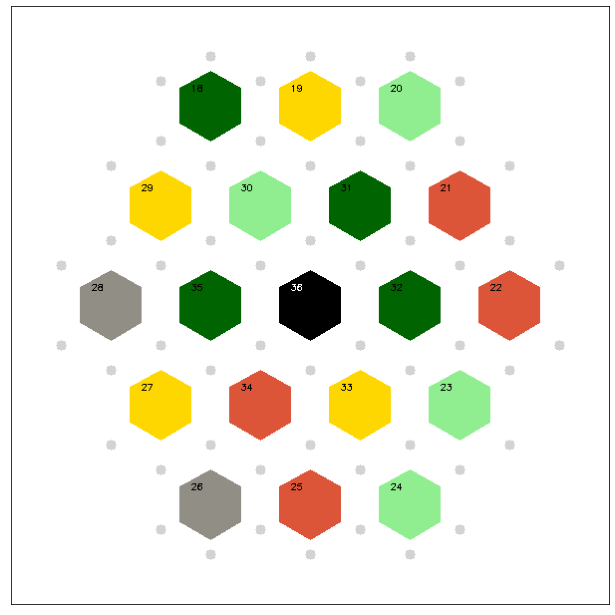

In [308]:
##############################
# Create simulated game board
##############################

blank_image = np.zeros((600,600,3), np.uint8)
blank_image[:] = 255

tile_num = [18, 19, 20, 29, 30, 31, 21, 28, 35, 36, 32, 22, 27, 34, 33, 23, 26, 25, 24]
XCoordinates = [200, 300, 400, 150, 250, 350, 450, 100, 200, 300, 400, 500, 150, 250, 350, 450, 200, 300, 400]
YCoordinates = [100, 100, 100, 200, 200, 200, 200, 300, 300, 300, 300, 300, 400, 400, 400, 400, 500, 500, 500]

settlementXCoodinates = [200, 300, 400, 150, 250, 350, 450, 150, 250, 350, 450, 100, 200, 300, 400, 500, 100, 200, 300, 400, 500, 50, 150, 250, 350, 450, 550, 50, 150, 250, 350, 450, 550, 100, 200, 300, 400, 500, 100, 200, 300, 400, 500, 150, 250, 350, 450, 150, 250, 350, 450, 200, 300, 400]
settlementYCoodinates = []
for i in range(3):
    settlementYCoodinates.append(50)
for i in range(4):
    settlementYCoodinates.append(75)
for i in range(4):
    settlementYCoodinates.append(135)
for i in range(5):
    settlementYCoodinates.append(160)
for i in range(5):
    settlementYCoodinates.append(235)
for i in range(6):
    settlementYCoodinates.append(260)
for i in range(6):
    settlementYCoodinates.append(340)
for i in range(5):
    settlementYCoodinates.append(365)
for i in range(5):
    settlementYCoodinates.append(440)
for i in range(4):
    settlementYCoodinates.append(465)
for i in range(4):
    settlementYCoodinates.append(525)
for i in range(3):
    settlementYCoodinates.append(550)

def typeToColor(type):
    woodColor = (0,100,0)
    sheepColor = (144,238,144)
    wheatColor = (255,215,0)
    stoneColor = (145, 142, 133)
    brickColor = (220, 85, 57)

    if type == "wheat":
        return wheatColor
    if type == "brick":
        return brickColor
    if type == "stone":
        return stoneColor
    if type == "wood":
        return woodColor
    if type == "sheep":
        return sheepColor

    return (0, 0, 0)

def get_point_from_angle_dist(orig, ang, dist):
    return (orig[0]+dist*math.cos(ang), orig[1]+dist*math.sin(ang))
    
def drawRoad(blank_image, first_pt, second_pt):
    box_w = 70
    box_h = 15
    ang = angleBetweenCircles(first_pt, second_pt)
    dist = np.sqrt((box_h/2)**2 + (box_w/2)**2)
    alpha = math.atan2((box_h/2),(box_w/2))
    beta = np.pi/2-alpha
    ang1 = ang+beta
    ang2 = ang1+2*alpha
    ang3 = ang-beta
    ang4 = ang3-2*alpha
    road_loc = (int((first_pt[0]+second_pt[0])/2), int((first_pt[1]+second_pt[1])/2))
    pt1 = get_point_from_angle_dist(road_loc, ang1, dist)
    pt2 = get_point_from_angle_dist(road_loc, ang2, dist)
    pt3 = get_point_from_angle_dist(road_loc, ang3, dist)
    pt4 = get_point_from_angle_dist(road_loc, ang4, dist)
    box_pts = np.array([[pt1],[pt2],[pt4],[pt3]],np.int32)
    box_pts = box_pts.reshape((-1, 1, 2))
    # cv.polylines(check_loc_img, [box_pts], True, (0,255,0), 2)
    cv.fillPoly(blank_image, [box_pts], (211, 211, 211))


coordinates = {}
for i in range(len(XCoordinates)):
    coordinates[tile_num[i]] = [XCoordinates[i], YCoordinates[i]]

    points = []
    cur_angle = -math.pi / 2
    for p in range(6):
        radius = 35
        pointX = XCoordinates[i] + radius * math.cos(cur_angle)
        pointY = YCoordinates[i] + radius * math.sin(cur_angle)
        cur_angle += math.pi / 3
        points.append([int(pointX), int(pointY)])
    points = np.asarray(points)
    points = points.reshape((-1,1,2)) 
    
    if (tile_num[i] == 36):
        cv.fillPoly(blank_image, [points], (0, 0, 0))
        cv.putText(blank_image, str(tile_num[i]), (XCoordinates[i] - 20, YCoordinates[i] - 15), cv.FONT_HERSHEY_SIMPLEX, .3, (255, 255, 255), 1)
    else:
        cur_color = typeToColor(tiles[tile_num[i]])
        cv.fillPoly(blank_image, [points], cur_color)
        cv.putText(blank_image, str(tile_num[i]), (XCoordinates[i] - 20, YCoordinates[i] - 15), cv.FONT_HERSHEY_SIMPLEX, .3, (0, 0, 0), 1)


for i in range(len(settlementXCoodinates)):
    cv.circle(blank_image, (settlementXCoodinates[i], settlementYCoodinates[i]), 5, (211, 211, 211), -1)
    



plt.figure(figsize=(11,11))
plt.imshow(blank_image)
plt.xticks([])
plt.yticks([])